Import libraries

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Preprocessing

In [ ]:
root_dirs = {
    'Train': r'D:\USTH\Nam Hai\MLADM2\final 2\dataset\Train',
    'Test': r'D:\USTH\Nam Hai\MLADM2\final 2\dataset\Test',
    'Validation': r'D:\USTH\Nam Hai\MLADM2\final 2\dataset\Validation'
}

output_root_dir = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed'

if not os.path.exists(output_root_dir):
    os.makedirs(output_root_dir)

for dataset_type, input_root_dir in root_dirs.items():
    output_dataset_dir = os.path.join(output_root_dir, dataset_type)
    if not os.path.exists(output_dataset_dir):
        os.makedirs(output_dataset_dir)
    subdirs = [os.path.join(input_root_dir, d) for d in os.listdir(input_root_dir) if os.path.isdir(os.path.join(input_root_dir, d))]

    for subdir in subdirs:
        label = os.path.basename(subdir)
        output_subdir = os.path.join(output_dataset_dir, label)
        if not os.path.exists(output_subdir):
            os.makedirs(output_subdir)
        files = os.listdir(subdir)
        pictures = [file for file in files if file.endswith('.jpg')]
        for picture in pictures:
            try:
                img_path = os.path.join(subdir, picture)
                img = Image.open(img_path)
                img = img.resize((128,128))
                img = img.convert('RGB')
                img_array = np.array(img)
                preprocessed_img_path = os.path.join(output_subdir, 'preprocessed_' + picture.split('.')[0] + '.jpg')
                cv2.imwrite(preprocessed_img_path, cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing file {img_path}: {e}")

print("Preprocessing Complete!")

Build and train model using MobileNetV2


In [1]:
train_dir = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Train'
test_dir = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test'
val_dir = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Validation'

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
val_gen = datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model.fit(train_gen, validation_data=val_gen, epochs=10)

for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(train_gen, validation_data=val_gen, epochs=10)

history = {}
for key in history1.history.keys():
    history[key] = history1.history[key] + history2.history[key]

with open(r'D:\USTH\Nam Hai\MLADM2\final 2\history.pkl', 'wb') as file:
    pickle.dump(history, file)

model_save_path = r'D:\USTH\Nam Hai\MLADM2\final 2\plant.keras'
model.save(model_save_path)
print(f'Model saved at {model_save_path}')

test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/10


C:\Users\ADM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.7533 - loss: 0.5418 - val_accuracy: 0.9833 - val_loss: 0.0712
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9753 - loss: 0.0641 - val_accuracy: 0.9833 - val_loss: 0.0895
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9940 - loss: 0.0335 - val_accuracy: 0.9833 - val_loss: 0.0860
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9961 - loss: 0.0154 - val_accuracy: 0.9833 - val_loss: 0.0747
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9833 - val_loss: 0.0681
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9833 - val_loss: 0.0744
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9833 - val_loss: 0.0793
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9833 - val

Visualize training and validation accuracy / loss

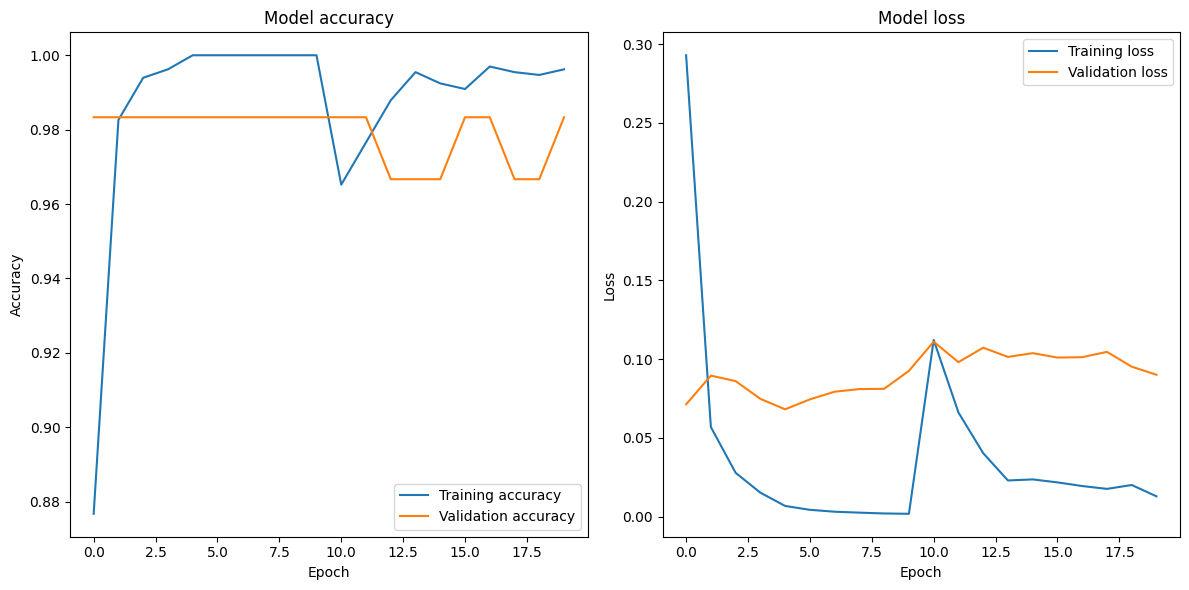

In [5]:
with open(r'D:\USTH\Nam Hai\MLADM2\final 2\history.pkl', 'rb') as file:
    history = pickle.load(file)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Classification testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


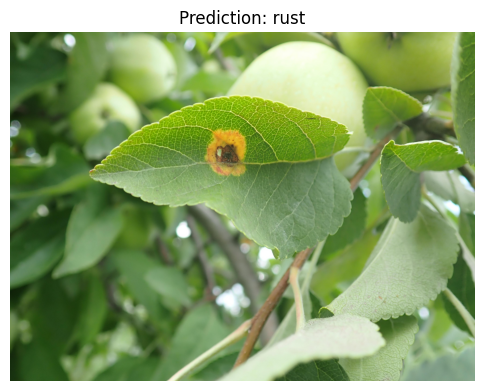

In [8]:
model = tf.keras.models.load_model(r'D:\USTH\Nam Hai\MLADM2\final 2\plant.keras')

def preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

def visualize(img_path):
    img_array = preprocess(img_path)
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = ['healthy', 'powdery', 'rust']
    predicted_label = class_labels[class_idx]
    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')
    plt.show()

img_path = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset\Test\Rust\83c2939deb266572.jpg'
visualize(img_path)

In [13]:
model = tf.keras.models.load_model(r'D:\USTH\Nam Hai\MLADM2\final 2\plant.keras')

def preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

def predict(directory_path):
    class_labels = ['healthy', 'powdery', 'rust']

    for subdir in ['Healthy', 'Powdery', 'Rust']:
        subdir_path = os.path.join(directory_path, subdir)
        images = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith('.jpg')]
        
        for img_path in images:
            img_array = preprocess(img_path)
            prediction = model.predict(img_array)
            class_idx = np.argmax(prediction, axis=1)[0]
            predicted_label = class_labels[class_idx]

            print(f"{img_path} -> Predicted: {predicted_label}")

directory_path = r'D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test'
predict(directory_path) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8ddaa5a5caa5caa8.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8ddaac1bd6c8cd0a.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8ddd5ec1c0de38c4.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8def3f60308ab41b.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8def4d91382175c3.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
D:\USTH\Nam Hai\MLADM2\final 2\dataset preprocessed\Test\Healthy\preprocessed_8df452e2e38c0b6e.jpg -> Predicted: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
D:\USTH